In [1]:
import sys
import os
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
ROOT = os.path.abspath('../')
sys.path.append(ROOT)
import models
from util import *
from sklearn import manifold
import re
import itertools

In [2]:
# import importlib
# importlib.reload(models)

In [3]:
%%time
DATA_DIR = os.path.join(ROOT,'data')
MODEL_DIR = os.path.join(ROOT,'models')
LOG_DIR = os.path.join(ROOT,'logs')
CHECKPT_DIR = os.path.join(LOG_DIR,'checkpoints')
ENCODE_DIR = os.path.join(LOG_DIR,'encodings')
# MODEL = 'jplu/tf-xlm-roberta-base' 
# MODEL = 'distilroberta-base' 
MODEL = 'distilbert-base-multilingual-cased'
N_EPOCHS = 2
BATCH_SIZE = 32
tf.keras.backend.clear_session()


Wall time: 1.98 ms


In [4]:
%%time
LOAD_ENCODING = True
SAVE_ENCODING = False
CLEAN = True
FILE_NAME = ENCODE_DIR+'\\{0}_encoding_clean_lower.npy'.format(MODEL.replace('/','-'))

if LOAD_ENCODING:
    with open(FILE_NAME,'rb') as f:
        x_train=np.load(f)
        y_train=np.load(f)
        x_validate=np.load(f)
        y_validate=np.load(f)
        x_test=np.load(f)
else:
    ## Load Data
    train_raw = pd.read_csv(os.path.join(DATA_DIR,'jigsaw-toxic-comment-train-processed-seqlen128.csv.zip'))
    train = pd.concat([train_raw.query('toxic==0').sample(60000,random_state=1),
                               train_raw.query('toxic==1')]).sample(frac=1)
    validation_data = pd.read_csv(os.path.join(DATA_DIR,'validation.csv.zip'))
    test_data = pd.read_csv(os.path.join(DATA_DIR,'test.csv.zip'))
    if CLEAN:
        train.comment_text = train.comment_text.apply(clean_text)
        test_data.content = test_data.content.apply(clean_text)
        validation_data.comment_text = validation_data.comment_text.apply(clean_text)
    ## Data encoding
    tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL)
    x_train = batch_encode(train.comment_text.values,tokenizer, max_len =  models.MAX_LEN)
    x_validate = batch_encode(validation_data.comment_text.values,tokenizer, max_len =  models.MAX_LEN)
    x_test = batch_encode(test_data.content.values,tokenizer, max_len =  models.MAX_LEN)
    y_train = train.toxic.values
    y_validate = validation_data.toxic.values
    # Free memory
    del(train_raw, train, validation_data,test_data)
    if SAVE_ENCODING:
        x_train_enc = np.array(x_train)
        y_train_enc = np.array(y_train)
        x_validate_enc = np.array(x_validate)
        y_validate_enc = np.array(y_validate)
        x_test_enc = np.array(x_test)
        with open(FILE_NAME,'wb') as f:
            np.save(f, x_train_enc)
            np.save(f, y_train_enc)
            np.save(f, x_validate_enc)
            np.save(f, y_validate_enc)
            np.save(f, x_test_enc)

Wall time: 8.29 s


In [5]:
%%time
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train,y_train))
                 .repeat(1)
                 .shuffle(2048)
                 .batch(BATCH_SIZE)
                 .prefetch(-1))

validate_dataset = (tf.data.Dataset.from_tensor_slices((x_validate,y_validate))
                    .batch(BATCH_SIZE)
                    .prefetch(-1))

test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
               .batch(BATCH_SIZE)
               .prefetch(-1))
# Free Space
del(x_train,y_train,x_validate,y_validate,x_test)

Wall time: 1.02 s


In [6]:
%%time
config = transformers.AutoConfig.from_pretrained(MODEL,output_hidden_states=True)
transformer = transformers.TFAutoModel.from_pretrained(MODEL,config=config)
model = models.distilbert_hs_mean_max_min_dense(transformer)
model.compile(tf.keras.optimizers.Adam(1e-5), tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), 
              metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])


Wall time: 3.07 s


In [7]:
# tensorboard setup
log_dir = os.path.join(LOG_DIR,'fit') +'\\' +datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,update_freq='batch')

## Test
# tensorboard_callback= AddtionalValidationTB(additional_validation_sets=[(test_dataset,'additional')],verbose=0,log_dir=log_dir, histogram_freq=1,update_freq='batch')
# training
train_hist = model.fit(train_dataset,validation_data=validate_dataset,epochs=10,callbacks=[tensorboard_callback])

Epoch 1/10
19/19 [==============================] - 22s 1s/step - loss: 0.6249 - binary_accuracy: 0.6750 - auc: 0.5716 - val_loss: 0.5869 - val_binary_accuracy: 0.8000 - val_auc: 0.6905 - val_additionalloss: 0.0000e+00 - val_additionalbinary_accuracy: 0.0000e+00 - val_additionalauc: 0.0000e+00
Epoch 2/10
19/19 [==============================] - 19s 1s/step - loss: 0.5493 - binary_accuracy: 0.7450 - auc: 0.7519 - val_loss: 0.5502 - val_binary_accuracy: 0.9000 - val_auc: 0.8095 - val_additionalloss: 0.0000e+00 - val_additionalbinary_accuracy: 0.0000e+00 - val_additionalauc: 0.0000e+00
Epoch 3/10
19/19 [==============================] - 19s 1s/step - loss: 0.5137 - binary_accuracy: 0.7833 - auc: 0.8052 - val_loss: 0.6398 - val_binary_accuracy: 0.6000 - val_auc: 0.7143 - val_additionalloss: 0.0000e+00 - val_additionalbinary_accuracy: 0.0000e+00 - val_additionalauc: 0.0000e+00
Epoch 4/10
19/19 [==============================] - 20s 1s/step - loss: 0.4594 - binary_accuracy: 0.8183 - auc: 0.8

In [7]:
model.evaluate(validate_dataset, return_dict=True)

1/1 [==============================] - 0s 998us/step - loss: 0.5815 - binary_accuracy: 0.7000 - auc: 0.8333


{'loss': 0.5814746022224426,
 'binary_accuracy': 0.699999988079071,
 'auc': 0.8333333134651184}

In [8]:
validate_predict = model.predict(validate_dataset)

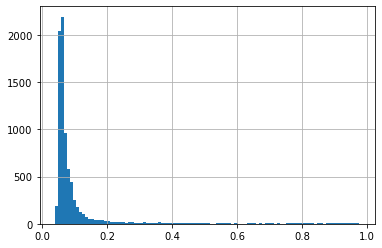

In [9]:
plt.hist(validate_predict, bins=100)
plt.grid(True)

In [11]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL)
validation_data_en = pd.read_csv(os.path.join(DATA_DIR,'compressed_validation_en.csv.zip'))
validation_data_en.comment_text = validation_data_en.comment_text.apply(clean_text)
x_validate_en = batch_encode(validation_data_en.comment_text.values,tokenizer, max_len =  models.MAX_LEN)
y_validate_en = validation_data_en.toxic.values

In [15]:
# validate on validation dataset
model_1_pred = model.predict(x_validate_en,verbose=1)
auc_metric =  tf.keras.metrics.AUC(num_thresholds=200)
auc_metric.reset_states()
_ = auc_metric.update_state(y_validate_en,model_1_pred.squeeze())
model_1_auc = auc_metric.result().numpy()

accuracy_metric = tf.keras.metrics.BinaryAccuracy()
accuracy_metric.update_state(y_validate_en,model_1_pred.squeeze())
model_1_acc = accuracy_metric.result().numpy()


print(f"Model 1 AUC:{model_1_auc}")
print(f"Model 1 ACC:{model_1_acc}")

250/250 [==============================] - 32s 129ms/step
Model 1 AUC:0.8857415914535522
Model 1 ACC:0.8707500100135803


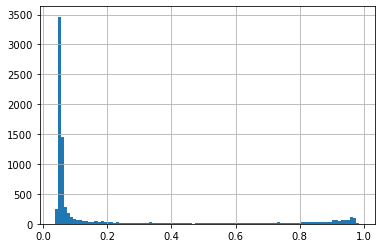

In [16]:
plt.hist(model_1_pred, bins=100)
plt.grid(True)